In [3]:
# ────── Cell 1: Install dependencies ──────
# ────── Cell 1: Install dependencies ──────
# (Only run this once; rerun if you add new packages)
%pip install --quiet \
    torch torchvision torchmetrics matplotlib scikit-image tqdm psutil

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
print(torch.__version__)


2.7.0+cpu


In [3]:
%pip install --quiet ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [8]:
# ────── Cell 2: Imports & Configuration ──────
import time, random, math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import random_shapes

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
from torchmetrics.classification import Accuracy
from tqdm.auto import tqdm

import psutil

# Notebook-wide settings
plt.rcParams["figure.dpi"] = 110
device = torch.device("cpu")
RNG = np.random.default_rng(42)
CLASS_NAMES = ["circle", "rectangle", "triangle"]

# Base output directory
BASE_DIR = Path(r"C:\Users\IAGhe\OneDrive\Documents\Learning\Python")
BASE_DIR.mkdir(parents=True, exist_ok=True)


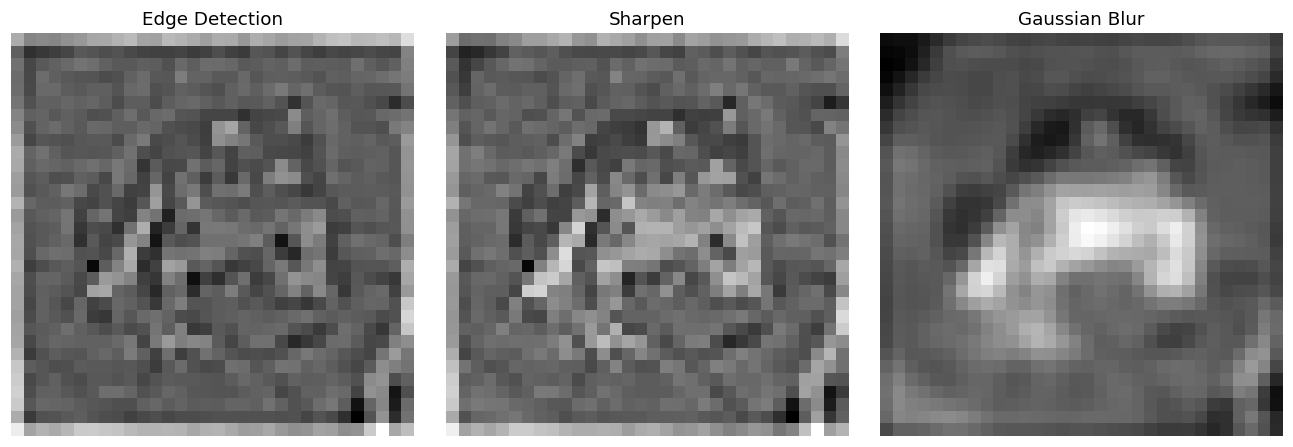

Saved convolution figure to C:\Users\IAGhe\OneDrive\Documents\Learning\Python\convolution_demo.png


In [10]:
# ────── Cell 3: Convolution from scratch ──────
# 1. Load a CIFAR-10 image
train_ds = datasets.CIFAR10(root="data/", train=True, download=True)
img_pil, label = train_ds[0]              
img_np = np.array(img_pil)               

# 2. Greyscale
grey = img_np.mean(axis=2)

# 3. Pure-NumPy conv2d
def conv2d(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    H, W = image.shape
    kH, kW = kernel.shape
    pad_h, pad_w = kH//2, kW//2
    padded = np.pad(image, ((pad_h,pad_h),(pad_w,pad_w)), mode="constant")
    out = np.zeros_like(image)
    for i in range(H):
        for j in range(W):
            out[i,j] = np.sum(padded[i:i+kH, j:j+kW] * kernel)
    return out

# 4. Define kernels
kernels = {
    "Edge Detection": np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]),
    "Sharpen":         np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]),
    "Gaussian Blur":   (1/16)*np.array([[1,2,1],[2,4,2],[1,2,1]])
}

# 5. Plot + save
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, (name, kern) in zip(axes, kernels.items()):
    ax.imshow(conv2d(grey, kern), cmap="gray")
    ax.set_title(name)
    ax.axis("off")

fig.tight_layout()
conv_path = BASE_DIR / "convolution_demo.png"
fig.savefig(conv_path)
plt.show()
print(f"Saved convolution figure to {conv_path}")


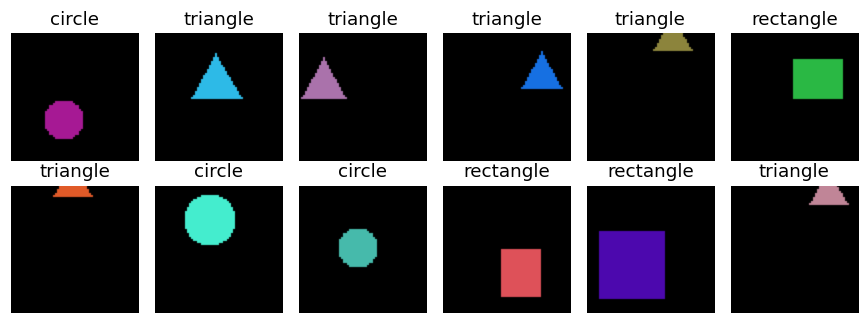

Saved shapes preview to C:\Users\IAGhe\OneDrive\Documents\Learning\Python\shapes_preview.png


In [12]:
# ────── Cell 4: Shapes dataset & DataLoaders ──────
from skimage.draw import random_shapes

# Map only our three classes
LABEL_MAP = {"circle": 0, "rectangle": 1, "triangle": 2}

def make_shape_img(img_size=64):
    while True:
        # Generate one image + metadata
        result, shape_info = random_shapes(
            (img_size, img_size),
            min_shapes=1,
            max_shapes=1,
            min_size=20,
            max_size=40,
            allow_overlap=False,
            num_channels=3
        )
        result[result == 255] = 0

        info = shape_info[0]
        if isinstance(info, dict):
            shape_name = info.get("label")
        else:
            shape_name = info[0]

        # Only accept our three labels
        if shape_name in LABEL_MAP:
            idx = LABEL_MAP[shape_name]
            return result, idx
        # Otherwise loop again and redraw

class ShapesDataset(Dataset):
    def __init__(self, n_samples, transform=None):
        self.n        = n_samples
        self.transform = transform
    def __len__(self):
        return self.n
    def __getitem__(self, i):
        img, lbl = make_shape_img()
        if self.transform:
            img = self.transform(img)
        return img, lbl

# Transforms & DataLoaders
tfm      = Compose([ToTensor(), Normalize((0.5,)*3, (0.5,)*3)])
train_ds = ShapesDataset(2000, tfm)
val_ds   = ShapesDataset(400,  tfm)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=128)

# Preview & save
fig, axes = plt.subplots(2, 6, figsize=(8, 3))
for ax in axes.ravel():
    img, lbl = train_ds[random.randrange(len(train_ds))]
    disp     = img.permute(1, 2, 0) * 0.5 + 0.5
    ax.imshow(disp)
    ax.set_title(CLASS_NAMES[lbl])
    ax.axis("off")

fig.tight_layout()
preview_path = BASE_DIR / "shapes_preview.png"
fig.savefig(preview_path)
plt.show()
print(f"Saved shapes preview to {preview_path}")


In [13]:
# ────── Cell 5: Define TinyCNN ──────
class TinyCNN(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,16,5,padding=2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),      nn.Flatten(),
            nn.Linear(64,n_classes)
        )
    def forward(self, x): return self.net(x)

model = TinyCNN().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Total parameters: 24,547


In [14]:
# ────── Cell 6: Training & validation ──────
criterion   = nn.CrossEntropyLoss()
optimiser   = optim.Adam(model.parameters(), lr=1e-3)
metric      = Accuracy(task="multiclass", num_classes=3).to(device)
n_epochs    = 10
best_val    = 0.0
train_losses, val_accs = [], []

for epoch in range(1, n_epochs+1):
    # — Training —
    model.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch}/{n_epochs}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimiser.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_dl.dataset)
    train_losses.append(epoch_loss)

    # — Validation —
    model.eval()
    metric.reset()
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            metric.update(model(xb), yb)
    val_acc = metric.compute().item()
    val_accs.append(val_acc)
    print(f"Epoch {epoch}: val accuracy = {val_acc:.2%}")

    # — Checkpoint —
    if val_acc > best_val:
        best_val = val_acc
        ckpt_path = BASE_DIR / "best_shapes_cnn.pt"
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ↳ saved new best model to {ckpt_path}")

print(f"\nFinished — best accuracy: {best_val:.2%}")


Epoch 1/10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: val accuracy = 44.50%
  ↳ saved new best model to C:\Users\IAGhe\OneDrive\Documents\Learning\Python\best_shapes_cnn.pt


Epoch 2/10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: val accuracy = 57.25%
  ↳ saved new best model to C:\Users\IAGhe\OneDrive\Documents\Learning\Python\best_shapes_cnn.pt


Epoch 3/10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: val accuracy = 50.00%


Epoch 4/10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: val accuracy = 64.75%
  ↳ saved new best model to C:\Users\IAGhe\OneDrive\Documents\Learning\Python\best_shapes_cnn.pt


Epoch 5/10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: val accuracy = 63.00%


Epoch 6/10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: val accuracy = 59.75%


Epoch 7/10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: val accuracy = 59.00%


Epoch 8/10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: val accuracy = 66.50%
  ↳ saved new best model to C:\Users\IAGhe\OneDrive\Documents\Learning\Python\best_shapes_cnn.pt


Epoch 9/10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: val accuracy = 59.25%


Epoch 10/10:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: val accuracy = 71.00%
  ↳ saved new best model to C:\Users\IAGhe\OneDrive\Documents\Learning\Python\best_shapes_cnn.pt

Finished — best accuracy: 71.00%


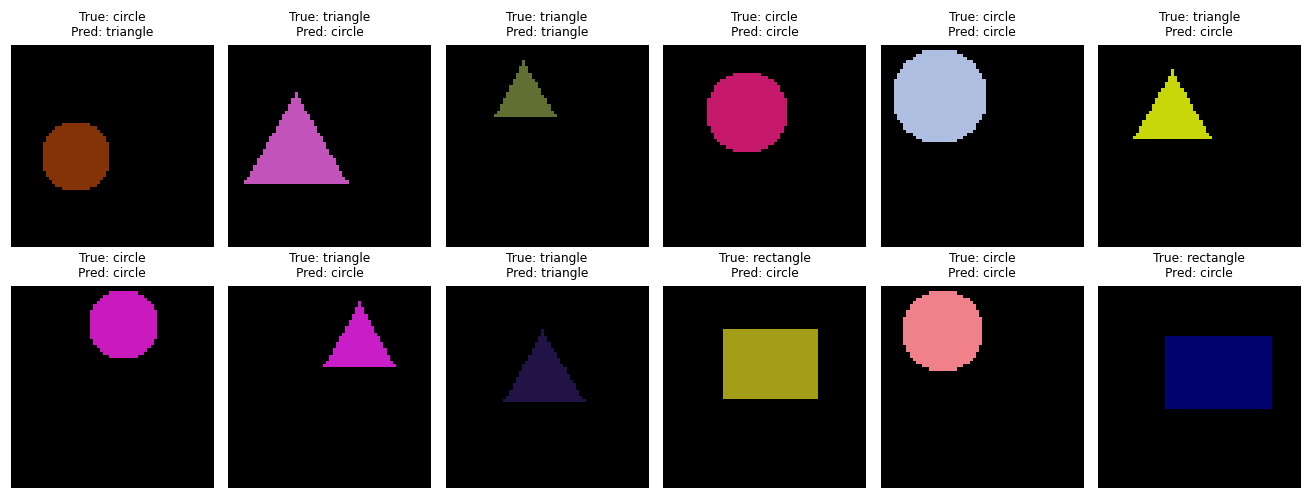

Saved inspection figure to C:\Users\IAGhe\OneDrive\Documents\Learning\Python\qualitative_inspection.png


In [17]:
# ────── Cell 7: Qualitative inspection (revised) ──────
model.load_state_dict(torch.load(BASE_DIR/"best_shapes_cnn.pt"))
model.eval()

def predict(img_tensor):
    with torch.no_grad():
        return model(img_tensor.unsqueeze(0).to(device)).argmax(dim=1).item()

# Bigger figure so there’s room for titles
fig, axes = plt.subplots(2, 6, figsize=(12, 5))

for ax in axes.ravel():
    img, lbl = val_ds[random.randrange(len(val_ds))]
    pred = predict(img)
    disp = img.permute(1, 2, 0) * 0.5 + 0.5

    ax.imshow(disp)
    # Two‐line title, small font
    ax.set_title(f"True: {CLASS_NAMES[lbl]}\nPred: {CLASS_NAMES[pred]}", 
                 fontsize=8)
    ax.axis("off")

# Tidy layout with extra top margin
plt.tight_layout(pad=1.0)
plt.subplots_adjust(top=0.90)
    
# Save & show
inspect_path = BASE_DIR / "qualitative_inspection.png"
fig.savefig(inspect_path, dpi=150)
plt.show()
print(f"Saved inspection figure to {inspect_path}")



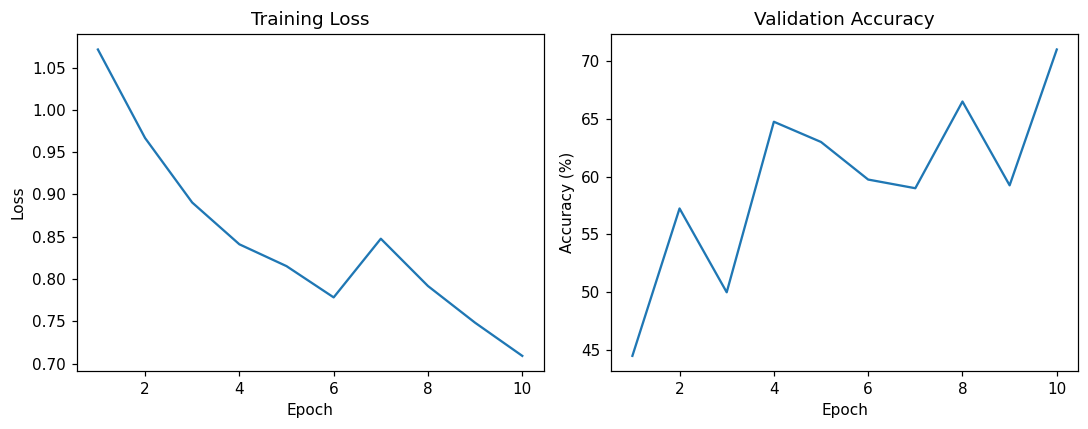

Saved training curves to C:\Users\IAGhe\OneDrive\Documents\Learning\Python\training_curves.png
Environment info saved to C:\Users\IAGhe\OneDrive\Documents\Learning\Python\env_info.txt


In [16]:
# ────── Cell 8: Results & logging ──────
# 1) Plot & save training curves
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(range(1, n_epochs+1), train_losses)
ax1.set(title="Training Loss", xlabel="Epoch", ylabel="Loss")
ax2.plot(range(1, n_epochs+1), [a*100 for a in val_accs])
ax2.set(title="Validation Accuracy", xlabel="Epoch", ylabel="Accuracy (%)")
fig.tight_layout()
curves_path = BASE_DIR / "training_curves.png"
fig.savefig(curves_path)
plt.show()
print(f"Saved training curves to {curves_path}")

# 2) Save environment info
env_info = {
    "torch": torch.__version__,
    "cpu_cores": psutil.cpu_count(),
    "total_ram_GB": psutil.virtual_memory().total / 1024**3
}
with open(BASE_DIR / "env_info.txt", "w") as f:
    for k, v in env_info.items():
        f.write(f"{k}: {v}\n")
print(f"Environment info saved to {BASE_DIR/'env_info.txt'}")
